In [1]:
# In Class Lab 7 Template

# import modules
import numpy as np
import astropy.units as u
from astropy.constants import G

# import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

# my modules
from ReadFile import Read
from CenterOfMass import CenterOfMass

In [2]:
# From In Class Lab 6 Solutions: 
# for plotting contours

#from https://gist.github.com/adrn/3993992

import scipy.optimize as so

def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(xdata, ydata, nbins_x, nbins_y, ax=None, **contour_kwargs):
    """ Create a density contour plot.
    Parameters
    ----------
    xdata : numpy.ndarray
    ydata : numpy.ndarray
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    ax : matplotlib.Axes (optional)
        If supplied, plot the contour to this axis. Otherwise, open a new figure
    contour_kwargs : dict
        kwargs to be passed to pyplot.contour()
    """

    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), normed=True)
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    pdf = (H*(x_bin_sizes*y_bin_sizes))

    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99))
    levels = [one_sigma, two_sigma, three_sigma][::-1]
    #labels = [0.68, 0.95, 0.99][::-1]

    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T

    fmt = {}
    strs = ['0.68', '0.95', '0.99'][::-1]

    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        plt.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)

    else:
        contour = ax.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        ax.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)
    return contour

In [3]:
# Create a COM of object for M31 Disk Using Code from Assignment 4
# modified CenterOfMass so that it doesn't return rounded values
COMD = CenterOfMass("M31_000.txt",2)

# Compute COM of M31 using disk particles
COMP = COMD.COM_P(0.1,4.0)
COMV = COMD.COM_V(COMP[0],COMP[1],COMP[2])

# Determine positions of disk particles relative to COM 
xD = COMD.x - float(COMP[0]/u.kpc)
yD = COMD.y - float(COMP[1]/u.kpc)
zD = COMD.z - float(COMP[2]/u.kpc)

# total magnitude
rtot = np.sqrt(xD**2 + yD**2 + zD**2)

# Determine velocities of disk particles relatiev to COM motion
vxD = COMD.vx - float(COMV[0]/u.km*u.s)
vyD = COMD.vy - float(COMV[1]/u.km*u.s)
vzD = COMD.vz - float(COMV[2]/u.km*u.s)

# total velocity 
vtot = np.sqrt(vxD**2 + vyD**2 + vzD**2)

# Vectors
r = np.array([xD,yD,zD]).T
v = np.array([vxD,vyD,vzD]).T

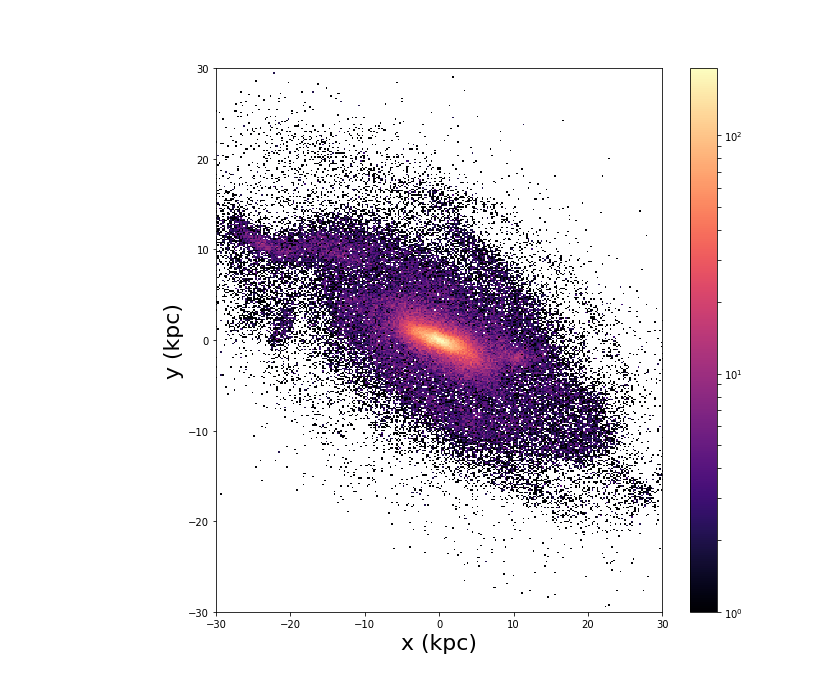

In [4]:
# M31 Disk Density 
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# plot the particle density for M31 
plt.hist2d(xD, yD, bins=500, norm=LogNorm(), cmap='magma')
plt.colorbar()

# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('y (kpc)', fontsize=22)

#set axis limits
plt.ylim(-30,30)
plt.xlim(-30,30)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

## In the same plane, now weight the data by the velocity along the line of sight using plt.scatter()

## Refine the velocity such that only the particles with a TOTAL velocity < 300 km/s and greater than -300 km/s are chosen. This will choose the particles that most closely follow the rotation curve. (Make sure you still plot the velocity along the line of sight)

(-40, 40)

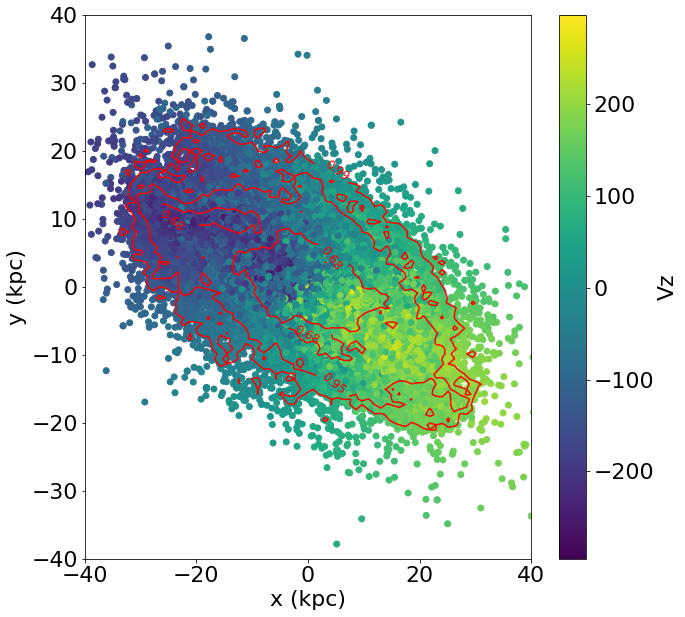

In [5]:
# Plot velocity weighted 

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# pick only the rotating stars following roughly the rotation curve -- EDIT HERE 
index = np.where(np.abs(vtot) < 300)

# plot position of disk particles color coded by velocity along the 3rd axis -- PLACE CODE BELOW
plt.scatter(xD[index], yD[index], c=vzD[index])
#plt.scatter(xD, yD, c=vzD)


#colorbar
cbar = plt.colorbar()
cbar.set_label(r'Vz', size=22)

# make the contour plot
density_contour(xD, yD, 100, 100, ax=ax, colors=['red', 'red', 'red'])


# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('y (kpc)', fontsize=22)


#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

#set axis limits
plt.ylim(-40,40)
plt.xlim(-40,40)

## The function below will rotate the position and velocity vectors so that the disk angular momentum is aligned with z axis. 

## Input: Arrays of 3D position and velocity vectors.
## Output: Re-oriented 3D positiong and velocity vectors.

In [6]:
def RotateFrame(posI,velI):
    # input:  3D array of positions and velocities
    # returns: 3D array of rotated positions and velocities such that j is in z direction

    # compute the angular momentum
    L = np.sum(np.cross(posI,velI), axis=0)
    # normalize the vector
    L_norm = L/np.sqrt(np.sum(L**2))


    # Set up rotation matrix to map L_norm to z unit vector (disk in xy-plane)
    
    # z unit vector
    z_norm = np.array([0, 0, 1])
    
    # cross product between L and z
    vv = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(vv**2))
    
    # dot product between L and z 
    c = np.dot(L_norm, z_norm)
    
    # rotation matrix
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
    R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2

    # Rotate coordinate system
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T
    
    return pos, vel



## Using the same TOTAL velocity mask from above, apply RotateFrame to M31's disk particle position and velocity vectors.

In [7]:
# determine the rotated velocity vectors -- EDIT BELOW
rn, vn =  RotateFrame(r[index],v[index])

## Plot the velocity weighted disk face on again using the rotated vectors.

## Hint: Remember that RotateFrame outputs vectors, so you'll want to plot the components of the rotated vectors.

(-40, 40)

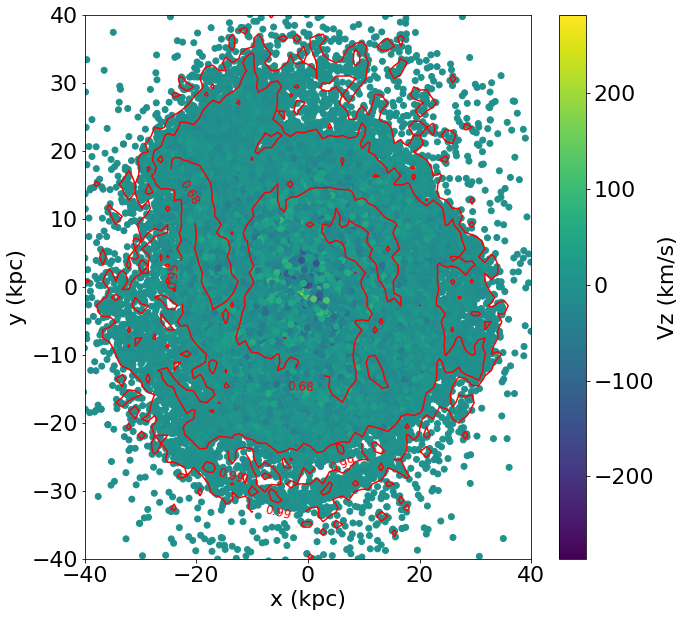

In [8]:
# Plot velocity weighted FACE ON DISK with rotated vectors

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# plot position of disk particles color coded by velocity along the 3rd axis -- EDIT BELOW
plt.scatter(rn[:,0],rn[:,1] ,c=vn[:,2])

#colorbar
cbar = plt.colorbar()
cbar.set_label(r'Vz (km/s)', size=22)

# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('y (kpc)', fontsize=22)

#add contours
density_contour(rn[:,0],rn[:,1], 100, 100, ax=ax, colors=['red', 'red', 'red'])

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

#set axis limits
plt.ylim(-40,40)
plt.xlim(-40,40)


## Plot the velocity weighted edge-on disk using the rotated vectors. Recall the set of components to get an edge-on view.

(-40, 40)

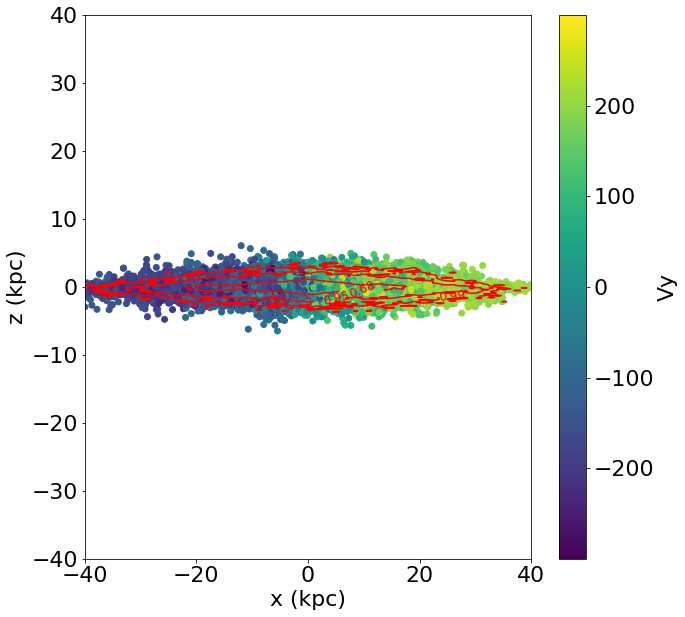

In [9]:
# Plot velocity weighted EDGE ON DISK
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# plot position of disk particles color coded by velocity along the 3rd axis
plt.scatter(rn[:,0],rn[:,2],c=vn[:,1])

#colorbar
cbar = plt.colorbar()
cbar.set_label(r'Vy', size=22)

# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('z (kpc)', fontsize=22)

density_contour(rn[:,0],rn[:,2], 100, 100, ax=ax, colors=['red', 'red', 'red'])


#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

#set axis limits
plt.ylim(-40,40)
plt.xlim(-40,40)
